In [153]:
# Import necessary libraries
import os
import logging
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.linalg import matrix_rank
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import shap  # For model interpretability
from sklearn.feature_selection import SelectFromModel  # For feature importance
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

In [154]:

# Dataset paths
train_path = "Dataset-HAR-Monitoring/train.csv"
test_path = "Dataset-HAR-Monitoring/test.csv"

# Define target_names
target_names = ['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

# Load Data
def load_data(train_path, test_path):
    """Load train and test datasets."""
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

# Feature Engineering
def create_additional_features(df):
    """Create additional features like magnitude and rolling statistics."""
    # Magnitude of acceleration
    df['tBodyAcc_mag'] = np.sqrt(df['tBodyAcc-mean()-X']**2 + 
                                  df['tBodyAcc-mean()-Y']**2 + 
                                  df['tBodyAcc-mean()-Z']**2)
    
    # Rolling statistics
    df['tBodyAcc-mean()-X_rolling_mean'] = df['tBodyAcc-mean()-X'].rolling(window=5).mean()
    df['tBodyAcc-mean()-X_rolling_std'] = df['tBodyAcc-mean()-X'].rolling(window=5).std()
    
    return df

# EDA Check
def EDA_check(train, test):
    """Perform exploratory data analysis."""
    print("\n--- Performing EDA ---")
    data_overview(train, test)
    basic_statistics(train)
    class_distribution(train)
    missing_data(train)
 #   feature_relationships(train)
 #   feature_distributions(train)

# Sub Methods for EDA
def data_overview(train, test):
    """Display basic information about the datasets."""
    print("\n--- TRAIN DATA OVERVIEW ---")
    print(train.info())
    print(train.head())
    print("Shape:", train.shape)

    print("\n--- TEST DATA OVERVIEW ---")
    print(test.info())
    print(test.head())
    print("Shape:", test.shape)

def basic_statistics(train):
    """Display basic statistics and column information."""
    print("\n--- BASIC STATISTICS ---")
    print(train.describe())
    print("\nUnique values per column:")
    print(train.nunique())

    cat_cols = train.select_dtypes(include=['object']).columns
    num_cols = train.select_dtypes(include=['float64', 'int64']).columns
    print("\nCategorical Columns:", cat_cols)
    print("\nNumerical Columns:", num_cols)

def class_distribution(train):
    """Plot the distribution of target classes."""
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Activity', data=train)
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

def missing_data(data):
    """Check for missing values in the dataset."""
    print("Checking for missing data started...")
    try:
        if isinstance(data, pd.DataFrame):
            missing = data.isnull().sum()
            print("\n--- MISSING DATA ---")
            print(missing[missing > 0])

            print("\n--- DUPLICATES ---")
            duplicates = train.duplicated().sum()
            print(f"Number of duplicate rows: {duplicates}")
        
        elif isinstance(data, np.ndarray):
            missing = np.isnan(data).sum()
            print("\n--- MISSING DATA ---")
            print(f"Missing values: {missing}")


            print("\n--- DUPLICATES ---")
            # Get unique elements and their counts
            unique_elements, counts = np.unique(data, return_counts=True)
            # Identify duplicates
            duplicates = unique_elements[counts > 1]
            print(f"Number of duplicate rows: {duplicates}")
        else:
            print("Unsupported data type for missing data check.")
        print("Checking for missing data ended...")
    except Exception as e:
        print("Error in missing_data: {e}")

def feature_relationships(train):
    """Plot feature correlation matrix."""
    print("Feature relationships method started...")
    try:
        numeric_train = train.select_dtypes(include=['float64', 'int64'])
        correlation_matrix = numeric_train.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.1)
        plt.title('Feature Correlation Matrix')
        plt.show()
        print("Feature relationships method ended successfully!")
    except Exception as e:
        print(f"Error: {e}")

def feature_distributions(train):
    """Plot feature distributions."""
    print("Feature distributions method started...")
    try:
        num_features = train.shape[1]
        features_per_plot = 100  # Number of features per subplot
        num_plots = int(np.ceil(num_features / features_per_plot))

        # Plot histograms in batches
        for i in range(num_plots):
            start_col = i * features_per_plot
            end_col = min((i + 1) * features_per_plot, num_features)

            train.iloc[:, start_col:end_col].hist(figsize=(16, 12), bins=30)
            plt.suptitle(f'Feature Distribution (Columns {start_col+1} to {end_col})')
            plt.show()

        # Plot boxplots in smaller groups
        boxplot_features = 100  # Number of features per boxplot
        num_boxplots = int(np.ceil(num_features / boxplot_features))

        for i in range(num_boxplots):
            start_col = i * boxplot_features
            end_col = min((i + 1) * boxplot_features, num_features)

            plt.figure(figsize=(12, 6))
            sns.boxplot(data=train.iloc[:, start_col:end_col])
            plt.title(f'Boxplot of Features {start_col+1} to {end_col}')
            plt.xticks(rotation=90)
            plt.show()
        print("Feature distributions method ended successfully!")
    except Exception as e:
        print(f"Error: {e}")




def data_preprocessing(train, test):
    """Preprocess data: scaling, PCA, and feature selection."""
    logging.info("Preprocessing Data method started...")
    try:
        # Feature Engineering
        train = create_additional_features(train)
        test = create_additional_features(test)

        # Separate features and target early
        y_train = train['Activity']
        y_test = test['Activity']
        X_train = train.drop(columns=['Activity'], errors='ignore')
        X_test = test.drop(columns=['Activity'], errors='ignore')

        # Handle missing data
        logging.info("Checking missing data in preprocessing")
        missing_data(X_train)

        # Handle missing values using mean imputation
        imputer = SimpleImputer(strategy="mean")
        X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

        # Remove constant features
        X_train, X_test = remove_constant_features(X_train, X_test)

        # Remove linearly dependent features
        X_train, X_test = remove_linearly_dependent_features(X_train, X_test)

        # Remove perfectly correlated features
        X_train, X_test = remove_perfectly_correlated_features(X_train, X_test)

        # Remove highly correlated features
        X_train, X_test = remove_highly_correlated_features(X_train, X_test)

        # Remove high VIF features
        X_train, X_test, vif_data = remove_high_vif_features(X_train, X_test)

        # Encode the 'subject' column using OneHotEncoding
        subject_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_train_subject_encoded = subject_encoder.fit_transform(X_train[['subject']])
        X_test_subject_encoded = subject_encoder.transform(X_test[['subject']])

        # Drop the original 'subject' column
        X_train = X_train.drop(columns=['subject'], errors='ignore')
        X_test = X_test.drop(columns=['subject'], errors='ignore')

        # Apply scaling and PCA
        X_train_scaled, X_test_scaled, scaler, pca = preprocess_data(X_train, X_test)

        # Combine scaled features with encoded subject data
        X_train_final = np.hstack((X_train_scaled, X_train_subject_encoded))
        X_test_final = np.hstack((X_test_scaled, X_test_subject_encoded))

        # Encode target variable
        activity_encoder = LabelEncoder()
        y_train_encoded = activity_encoder.fit_transform(y_train)
        y_test_encoded = activity_encoder.transform(y_test)

        # Handle class imbalance
        X_resampled, y_resampled = handle_class_imbalance(X_train_final, y_train_encoded)
        logging.info("Preprocessing Data method ended successfully!")
        return X_resampled, y_resampled, X_test_final, y_test_encoded, scaler, pca, activity_encoder, subject_encoder
    except Exception as e:
        logging.error(f"Error in data_preprocessing: {e}")
        return None  # Return None if preprocessing fails




def remove_constant_features(X_train, X_test):
    """Remove features with zero variance (constant features)."""
    logging.info("Removing constant features...")
    try:
        selector = VarianceThreshold()  # Default threshold = 0
        X_train_transformed = selector.fit_transform(X_train)
        X_test_transformed = selector.transform(X_test)

        # Get the feature names after removing constant features
        feature_names = X_train.columns[selector.get_support()]
        X_train = pd.DataFrame(X_train_transformed, columns=feature_names)
        X_test = pd.DataFrame(X_test_transformed, columns=feature_names)

        logging.info(f"Removed {len(X_train.columns) - len(feature_names)} constant features.")
        return X_train, X_test
    except Exception as e:
        logging.error(f"Error in remove_constant_features: {e}")
        return X_train, X_test


def remove_linearly_dependent_features(X_train, X_test):
    """Remove features that are linear combinations of others."""
    logging.info("Removing linearly dependent features...")
    try:
        # Convert to NumPy array for SVD
        X_train_array = X_train.values

        # Calculate the rank of the feature matrix
        rank = matrix_rank(X_train_array)

        # If rank < number of features, there are linearly dependent features
        if rank < X_train_array.shape[1]:
            logging.info(f"Rank of feature matrix: {rank} (less than number of features)")
            # Use QR decomposition to identify linearly dependent features
            from scipy.linalg import qr
            Q, R = qr(X_train_array)
            linearly_dependent_features = np.where(np.abs(np.diag(R)) < 1e-10)[0]

            # Drop linearly dependent features
            X_train = X_train.drop(X_train.columns[linearly_dependent_features], axis=1)
            X_test = X_test.drop(X_test.columns[linearly_dependent_features], axis=1)

            logging.info(f"Removed {len(linearly_dependent_features)} linearly dependent features.")
        else:
            logging.info("No linearly dependent features found.")

        return X_train, X_test
    except Exception as e:
        logging.error(f"Error in remove_linearly_dependent_features: {e}")
        return X_train, X_test



def remove_perfectly_correlated_features(X_train, X_test):
    """Remove features that are perfectly correlated."""
    logging.info("Removing perfectly correlated features...")
    try:
        # Calculate the correlation matrix
        corr_matrix = X_train.corr().abs()

        # Find features with perfect correlation (correlation = 1)
        perfect_corr_features = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) == 1:
                    perfect_corr_features.add(corr_matrix.columns[i])

        # Drop perfectly correlated features
        X_train = X_train.drop(columns=perfect_corr_features, errors='ignore')
        X_test = X_test.drop(columns=perfect_corr_features, errors='ignore')

        logging.info(f"Removed {len(perfect_corr_features)} perfectly correlated features: {perfect_corr_features}")
        return X_train, X_test
    except Exception as e:
        logging.error(f"Error in remove_perfectly_correlated_features: {e}")
        return X_train, X_test






# Remove correlated Features
def remove_highly_correlated_features(X_train, X_test, threshold=0.97):
    """Remove features with correlation above the threshold."""
    logging.info("Remove highly correlated features method started...")
    try:
        # Calculate correlation matrix
        corr_matrix = X_train.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
        logging.info(f"Removing {len(to_drop)} highly correlated features: {to_drop}")

        # Drop correlated features
        X_train = X_train.drop(columns=to_drop, errors='ignore')
        X_test = X_test.drop(columns=to_drop, errors='ignore')

        logging.info("Remove highly correlated method ended successfully!")
        return X_train, X_test
    except Exception as e:
        logging.error(f"Error in remove_highly_correlated_features: {e}")
        return X_train, X_test


def remove_low_variance_features(X_train, X_test, threshold=1e-4):
    selector = VarianceThreshold(threshold)
    X_train = pd.DataFrame(selector.fit_transform(X_train), columns=X_train.columns[selector.get_support()])
    X_test = pd.DataFrame(selector.transform(X_test), columns=X_test.columns[selector.get_support()])
    return X_train, X_test



# Remove High VIF Features
def remove_high_vif_features(train, test, threshold=10):
    """Remove features with high VIF."""
    logging.info("Remove high VIF features method started...")
    try:
        # Drop non-numeric columns (e.g., 'subject')
        numeric_train = train.select_dtypes(include=['float64', 'int64'])
        numeric_test = test.select_dtypes(include=['float64', 'int64'])

        # Calculate VIF
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        vif_data = pd.DataFrame()
        vif_data["Feature"] = numeric_train.columns
        vif_values = []

        for i in range(numeric_train.shape[1]):
            try:
                vif = variance_inflation_factor(numeric_train.values, i)
                if np.isinf(vif) or np.isnan(vif):
                    # If VIF is infinite or NaN, set it to a very high value
                    vif_values.append(np.inf)
                else:
                    vif_values.append(vif)
            except:
                # If VIF calculation fails, set it to a very high value
                vif_values.append(np.inf)

        vif_data["VIF"] = vif_values

        # Drop features with VIF > threshold
        high_vif_features = vif_data[vif_data['VIF'] > threshold]['Feature'].tolist()
        logging.info(f"Dropping {len(high_vif_features)} features with VIF > {threshold}: {high_vif_features}")

        train_reduced = train.drop(columns=high_vif_features, errors='ignore')
        test_reduced = test.drop(columns=high_vif_features, errors='ignore')
        logging.info("Remove high VIF features method ended successfully!")
        return train_reduced, test_reduced, vif_data
    except Exception as e:
        logging.error(f"Error in remove_high_vif_features: {e}")
        return train, test, None  # Return original data if VIF calculation fails

def svd_vif(X):
    """Compute VIF using Singular Value Decomposition."""
    print("SVD VIF method started...")
    try:
        U, s, Vt = np.linalg.svd(X, full_matrices=False)
        vif_values = 1 / (s ** 2)
        print("SVD VIF method ended successfully!")
        return vif_values
    except Exception as e:
        print(f"Error: {e}")


def preprocess_data(X_train, X_test, variance_threshold=0.95):
    """Normalize features and apply PCA."""
    logging.info("Preprocess data method started...")
    try:
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        # Apply PCA
        pca = PCA(n_components=variance_threshold)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Use original feature names for PCA components
        loadings = pd.DataFrame(pca.components_, columns=X_train.columns)

        # Create descriptive names for each principal component
        feature_names = ["_".join(loadings.iloc[i].index.tolist()) for i in range(loadings.shape[0])]

        # Assign human-readable column names
        X_train_pca = pd.DataFrame(X_train_pca, columns=feature_names)
        X_test_pca = pd.DataFrame(X_test_pca, columns=feature_names)
        logging.info("Preprocess data method ended successfully!")
        return X_train_pca, X_test_pca, scaler, pca
    except Exception as e:
        logging.error(f"Error in preprocess_data: {e}")
        return X_train, X_test, None, None  # Return original data if PCA fails

# Check class imbalance
def check_class_imbalance(y_train, encoder):
    """Checks and visualizes class imbalance with actual activity names."""
    print("Check class imbalance method started...")
    try:
        label_counts = pd.Series(y_train).value_counts()

        # Convert numeric labels back to original activity names
        activity_labels = encoder.inverse_transform(label_counts.index)

        # Define colors for the pie chart
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'pink', 'purple']

        # Plot class distribution with activity names
        plt.figure(figsize=(6, 6))
        plt.pie(label_counts, labels=activity_labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title("Distribution of Activity Classes")
        plt.show()
        print("Check class imbalance method ended successfully!")
        return label_counts
    except Exception as e:
        print(f"Error: {e}")

# Handle class imbalance
def handle_class_imbalance(X_train, y_train):
    """Apply SMOTE to handle class imbalance."""
    print("Handle class imbalance method started...")
    try:
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        print("Handle class imbalance method ended successfully!")
        return X_resampled, y_resampled
    except Exception as e:
        print(f"Error: {e}")

# Tune hyperparameters
def tune_hyperparameters(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    print("Tune hyperparameters method started...")
    try:
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
        grid_search = GridSearchCV(
            RandomForestClassifier(random_state=42),
            param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        print(f"Best hyperparameters: {grid_search.best_params_}")
        print("Tune hyperparameters method ended successfully!")
        return grid_search.best_estimator_
    except Exception as e:
        print(f"Error: {e}")

# RandomForest Model Training and Evaluation
def randomforest_model_training_and_evaluation(algorithm_name, X_train, y_train, X_test, y_test):
    """Train and evaluate a Random Forest model."""
    print(f"\n--- Training and Evaluating {algorithm_name} Model ---")
    print("RandomForest model training and evaluation method started...")
    try:
        # Hyperparameter tuning
        best_model = tune_hyperparameters(X_train, y_train)

        # Initialize the model with the best hyperparameters
        model = RandomForestClassifier(
            n_estimators=best_model.n_estimators,
            max_depth=best_model.max_depth,
            min_samples_split=best_model.min_samples_split, random_state=42, class_weight="balanced"
        )
        print(f"{algorithm_name} model initialized with tuned hyperparameters.")

        # Perform cross-validation
        logging.info("Performing cross-validation...")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        print(f"Cross-validation accuracy scores: {cv_scores}")
        print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

        # Train the model
        model.fit(X_train, y_train)
        print("Model trained.")

        # Make predictions
        y_pred_random_forest = model.predict(X_test)
        print("Predictions made on the test set.")

        # Evaluate model performance
        evaluate_model(algorithm_name, y_test, y_pred_random_forest)
        print("Model evaluated.")
        print("RandomForest model training and evaluation method ended successfully!")
        return model, y_pred_random_forest
    except Exception as e:
        print(f"Error: {e}")

# Plot confusion matrix
def plot_confusion_matrix(cm, y_test):
    """Plot and save the confusion matrix."""
    print("Plot confusion matrix method started...")
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        print("Plot confusion matrix method ended successfully!")
    except Exception as e:
        print(f"Error: {e}")

# Evaluate model
def evaluate_model(algorithm_name, y_test, y_pred):
    """Evaluate the model's performance on the test set."""
    print("Evaluate model method started...")
    try:
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Print evaluation metrics
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Test F1-score: {f1:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print("\nClassification Report:\n" + report)

        # Plot confusion matrix
        plot_confusion_matrix(cm, y_test)
        print("Evaluate model method ended successfully!")
        return accuracy, report, cm
    except Exception as e:
        print(f"Error: {e}")



In [155]:
def cross_validate(model, X_train, y_train):
    """Perform cross-validation on the training data."""
    try:
        print(f"cross_validate method started...")
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        print(f"Cross-validation accuracy scores: {cv_scores}")
        print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")
        print(f"cross_validate method ended successfully!")
        return cv_scores
    except Exception as e:
        print(f"Error: {e}")


In [156]:
def svm_tune_hyperparameters(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    try:
        print(f"svm_tune_hyperparameters method started...")
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
        grid_search = GridSearchCV(
            SVC(random_state=42),
            param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        print(f"Best hyperparameters: {grid_search.best_params_}")
        print(f"svm_tune_hyperparameters method ended successfully!")
        return grid_search.best_estimator_
    except Exception as e:
        print(f"Error: {e}")

In [157]:
# SVM Model Training and Evaluation
def svm_model_training_and_evaluation(X_train, y_train, X_test, y_test, algorithm_name="SVM"):
    try:
        # Handle missing data
        print(f"Checking missing data in preprocessing")
        if isinstance(X_train, np.ndarray):
            X_train_df = pd.DataFrame(X_train)
            missing_data(X_train_df)
        else:
            missing_data(X_train)
    
        """Train, evaluate, and save an SVM model."""
        print("SVM model training and evaluation method started...")
        print(f"Training {algorithm_name} model...")

        # Hyperparameter tuning
        print("Starting hyperparameter tuning...")
        best_model = svm_tune_hyperparameters(X_train, y_train)
        print("Hyperparameter tuning completed.")

        # Initialize the model
        model_svm = SVC(
            C=best_model.C,
            kernel=best_model.kernel,
            random_state=42,
            probability=True  # Enable probability estimates
        )
        print(f"{algorithm_name} model initialized with tuned hyperparameters.")

        # Perform cross-validation
        logging.info("Performing cross-validation...")
        cv_scores = cross_validate(model_svm, X_train, y_train)
        print(f"Cross-validation accuracy scores: {cv_scores}")
        print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

        # Train the model
        model_svm.fit(X_train, y_train)
        print("Model trained.")

        # Make predictions on the test set
        y_pred_svm = model_svm.predict(X_test)
        print("Predictions made on the test set.")

        # Evaluate the model
        evaluate_model(algorithm_name, y_test, y_pred_svm)
        print("Model evaluated.")
        print("SVM model training and evaluation method ended successfully!")
        return model_svm, y_pred_svm
    except Exception as e:
        print(f"Error: {e}")

In [158]:


# CNN Model Training and Evaluation
def cnn_model_training_and_evaluation(X_train, y_train, X_test, y_test):
    """Train and evaluate a CNN model."""
    print("CNN model training and evaluation method started...")
    try:
        # Reshape data for CNN input
        X_train_reshaped = np.expand_dims(X_train, axis=-1)  # Shape: (samples, timesteps, 1)
        X_test_reshaped = np.expand_dims(X_test, axis=-1)    # Shape: (samples, timesteps, 1)

        # Define input shape and number of classes
        input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
        num_classes = len(np.unique(y_train))  # Number of unique classes in y_train
        print("Input shape:", input_shape)
        print("Number of classes:", num_classes)

        # Build the CNN model
        def build_cnn_model(input_shape, num_classes):
            """Build a CNN model."""
            model = Sequential([
                Conv1D(64, 3, activation='relu', input_shape=input_shape),
                BatchNormalization(),
                MaxPooling1D(2),
                Dropout(0.3),

                Conv1D(128, 3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(2),
                Dropout(0.3),

                Conv1D(256, 3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(2),
                Dropout(0.3),

                Flatten(),

                Dense(128, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),

                Dense(num_classes, activation='softmax')
            ])

            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            return model

        # Build the model
        model = build_cnn_model(input_shape, num_classes)
        model.summary()

        # Train the model with early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train_reshaped, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        # Make predictions
        y_pred_cnn = model.predict(X_test_reshaped).argmax(axis=1)

        # Classification report and confusion matrix
        print("Classification Report:")
        print(classification_report(y_test, y_pred_cnn))

        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_cnn))
        print("CNN model training and evaluation method ended successfully!")
        return model

    except Exception as e:
        print(f"Error: {e}")

# CNN-LSTM Hybrid Model Training and Evaluation
def hybrid_cnn_lstm_model_training_and_evaluation(X_train, y_train, X_test, y_test):
    """Train and evaluate a CNN-LSTM hybrid model."""
    print("CNN-LSTM hybrid model training and evaluation method started...")
    try:
        # Reshape data for CNN input
        X_train_reshaped = np.expand_dims(X_train, axis=-1)  # Shape: (samples, timesteps, 1)
        X_test_reshaped = np.expand_dims(X_test, axis=-1)    # Shape: (samples, timesteps, 1)

        # Define input shape and number of classes
        input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
        num_classes = len(np.unique(y_train))  # Number of unique classes in y_train
        print("Input shape:", input_shape)
        print("Number of classes:", num_classes)

        # Build the CNN-LSTM model
        def build_hybrid_model(input_shape, num_classes):
            """Build a CNN-LSTM hybrid model."""
            model = Sequential([
                Conv1D(64, 3, activation='relu', input_shape=input_shape),
                BatchNormalization(),
                MaxPooling1D(2),
                Dropout(0.3),

                Conv1D(128, 3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(2),
                Dropout(0.3),

                LSTM(64, return_sequences=True),
                Dropout(0.3),

                LSTM(32),
                Dropout(0.3),

                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),

                Dense(num_classes, activation='softmax')
            ])

            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            return model

        # Build the model
        model = build_hybrid_model(input_shape, num_classes)
        model.summary()

        # Train the model with early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train_reshaped, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        # Make predictions
        y_pred_hybrid = model.predict(X_test_reshaped).argmax(axis=1)

        # Classification report and confusion matrix
        print("Classification Report:")
        print(classification_report(y_test, y_pred_hybrid))

        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_hybrid))
        print("CNN-LSTM hybrid model training and evaluation method ended successfully!")
        return model
    except Exception as e:
        print(f"Error: {e}")

# Function to display predictions
def display_predictions(X_test, y_pred, y_test, model_name):
    """Display predictions in a user-friendly way."""
    print("Display predictions method started...")
    try:
        print(f"\n--- {model_name} Predictions ---")

        # Ensure X_train and y_train have the correct shapes
        print("X_test shape:", X_test.shape)
        print("y_test shape:", y_test.shape)

        # The model outputs probabilities, converting into class labels
        if y_pred.ndim > 1:
            y_pred = y_pred.argmax(axis=1)

        # Mapping predicted labels to target names
        predicted_target_names = [target_names[i] for i in y_pred]

        # Mapping original labels to target names
        original_target_names = [target_names[i] for i in y_test]

        # Let the user choose the offset and number of samples
        offset = 100  # Default offset
        num_samples = 5  # Default number of samples

        # Display top predictions at the selected offset
        print(f"Top {num_samples} Predictions at Offset {offset}:")
        results = []
        for i in range(offset, offset + num_samples):
            results.append({
                "Sample": i,
                "Predicted": predicted_target_names[i],
                "Original": original_target_names[i]
            })

        # Display results in a table
        print(pd.DataFrame(results))
        print("Display predictions method ended successfully!")
    except Exception as e:
        print(f"Error: {e}")



--- Performing EDA ---

--- TRAIN DATA OVERVIEW ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944  

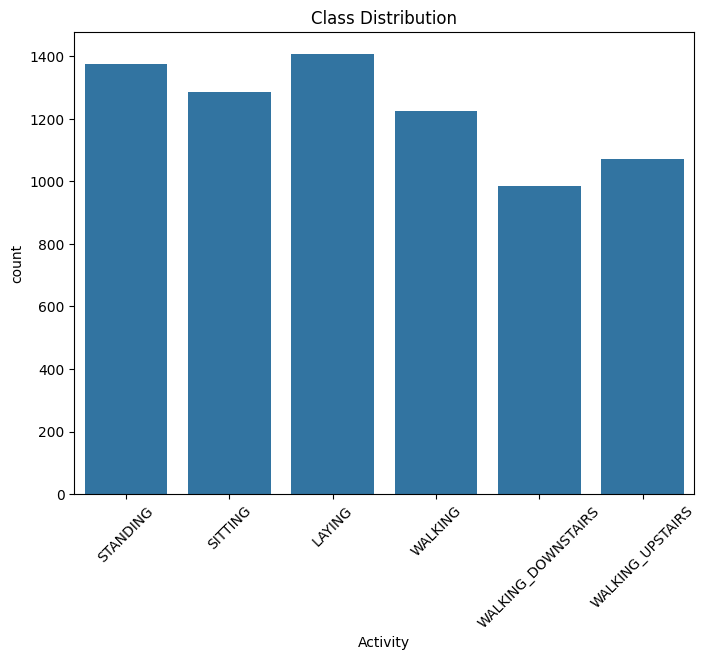

Checking for missing data started...

--- MISSING DATA ---
Series([], dtype: int64)

--- DUPLICATES ---
Number of duplicate rows: 0
Checking for missing data ended...


In [159]:
train, test = load_data(train_path, test_path)

# Perform EDA
EDA_check(train, test)

In [ ]:
# Preprocess data
X_train, y_train, X_test, y_test, scaler, pca, activity_encoder, subject_encoder = data_preprocessing(train, test)


Checking for missing data started...

--- MISSING DATA ---
tBodyAcc-mean()-X_rolling_mean    4
tBodyAcc-mean()-X_rolling_std     4
dtype: int64

--- DUPLICATES ---
Number of duplicate rows: 0
Checking for missing data ended...


In [ ]:
X_train.shape

In [ ]:
# Train and evaluate models
model_random_forest, y_pred_random_forest = randomforest_model_training_and_evaluation("RandomForest", X_train, y_train, X_test, y_test)
display_predictions(X_test, y_pred_random_forest, y_test, "RandomForest")

In [ ]:

# Main Execution
#if __name__ == "__main__":
    # Load data

model_svm, y_pred_svm = svm_model_training_and_evaluation(X_train, y_train, X_test, y_test)
display_predictions(X_test, y_pred_svm, y_test, "SVM")

model_cnn = cnn_model_training_and_evaluation(X_train, y_train, X_test, y_test)
y_pred_cnn = model_cnn.predict(np.expand_dims(X_test, axis=-1)).argmax(axis=1)
display_predictions(X_test, y_pred_cnn, y_test, "CNN")

model_hybrid = hybrid_cnn_lstm_model_training_and_evaluation(X_train, y_train, X_test, y_test)
y_pred_hybrid = model_hybrid.predict(np.expand_dims(X_test, axis=-1)).argmax(axis=1)
display_predictions(X_test, y_pred_hybrid, y_test, "CNN-LSTM Hybrid")